In [1]:
import sys

sys.path.insert(0, "..")

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm.notebook import tqdm

# Our modules
from src.agents.dqn_agent import DQNAgent
from src.mdp import RewardFunction
from src.agents.callbacks.learning_curve_callback import LearningCurveCallback
from src.agents.metrics import TrainingMetrics, EvaluationMetrics
from src.seeds import generate_seeds

# Plotting style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 4)

## 2. Environment Setup

In [18]:
# Configuration
EPISODE_LENGTH = 1000  # days

from src.seeds import TRAINING_SEED

EVAL_SEEDS = generate_seeds(100, start_index=100)

metadata = {
    "k": 30,
    "Q_max": 30,
    "episode_length": EPISODE_LENGTH,
}

print("🎲 DQN Training Seeds:")
print(f"   Training: {TRAINING_SEED}")
print(f"   Final evaluation: {len(EVAL_SEEDS)} seeds starting at {EVAL_SEEDS[0]}")

🎲 DQN Training Seeds:
   Training: 6173
   Final evaluation: 100 seeds starting at 2216


In [3]:
from src.environment.gym_env import InventoryEnvironment


def make_env(
    random_seed: int = TRAINING_SEED,
) -> InventoryEnvironment:
    return InventoryEnvironment(
        k=metadata["k"],
        Q_max=metadata["Q_max"],
        episode_length=metadata["episode_length"],
        random_seed=random_seed,
    )


env = make_env(random_seed=TRAINING_SEED)
print(env)

Inventory Management Gym Environment (k=30, Q_max=30, episode_length=1000)


## 3. Create and Train DQN Agent

In [ ]:
agent = DQNAgent(
    env=env,
    learning_rate=1e-4,
    gamma=0.99,
    buffer_size=100_000,
    batch_size=64,
    exploration_fraction=0.3,
    exploration_final_eps=0.05,
    target_update_interval=1000,
    learning_starts=1000,
    train_freq=4,
    tensorboard_log=None,
    policy_kwargs=dict(net_arch=[256, 256]),
    seed=TRAINING_SEED,
    verbose=0,
)

print(f"DQN Agent created with seed {TRAINING_SEED}")

DQN Agent created with seed 6173


## 5. Training

Train the DQN agent with periodic evaluation.

**Monitor with TensorBoard:**

```bash
tensorboard --logdir=./logs
```


In [ ]:
TOTAL_TIMESTEPS = 10_000_000

print(f"🚀 Starting training for {TOTAL_TIMESTEPS:,} timesteps...")
print(f"   ≈ {TOTAL_TIMESTEPS // EPISODE_LENGTH:,} episodes\n")

# Initialize plot classes
training_plots = TrainingMetrics()
evaluation_plots = EvaluationMetrics()

# Callbacks
learning_curve_callback = LearningCurveCallback()

agent.train(
    total_timesteps=TOTAL_TIMESTEPS,
    progress_bar=True,
    callbacks=learning_curve_callback,
)

print(f"Training complete!")

Output()

🚀 Starting training for 10,000,000 timesteps...
   ≈ 10,000 episodes



Training complete!


## 6. Save the Trained Model

In [6]:
agent.save(metadata=metadata)

DQN model saved to models
  Metadata: k=30, Q_max=30


---

# Phase 1: Training Analysis


### 1. Learning Curve (Training Stability)

Average Reward per Episode vs. Timesteps with baseline comparison.


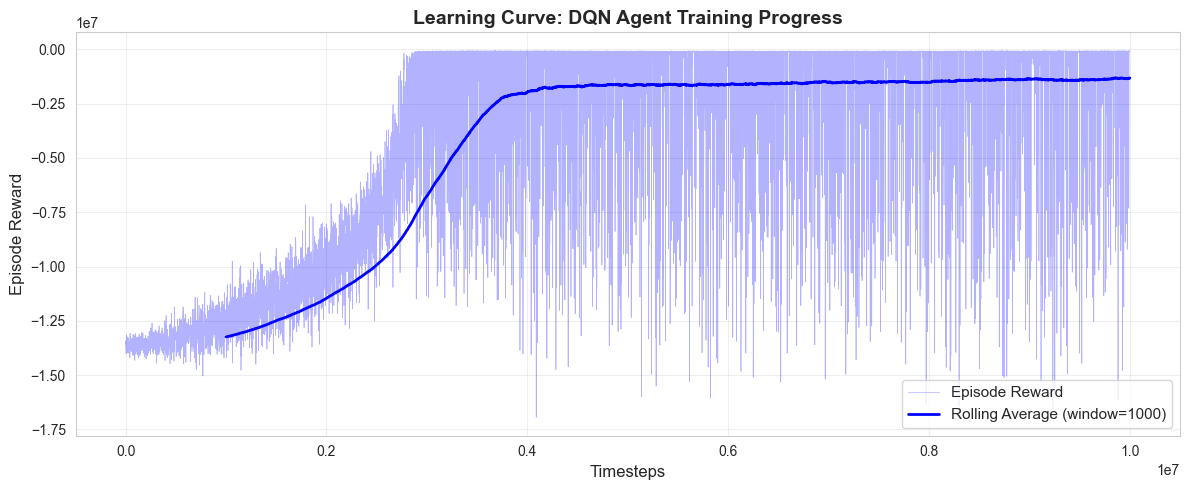

📊 Training Statistics:
  Total Episodes: 10000
  Total Timesteps: 10000000
  Episode Length: 1000.00 timesteps

  -- Performance (Last 1000 episodes) --
  Mean Reward:   -1320405.88 ± 3039685.75
  Min Reward:    -16561515.00
  Max Reward:    -61717.00

  -- Specifics --
  Best Ever Reward: -61717.00
  Last Ep Reward:   -74069.00

 -- Daily Rewards --
  Mean Reward per Day: -4239.72 ± 5179.11
  Final Mean Reward per Day (last 1000 eps): -1320.41 ± 3039.69


In [7]:
window = int(0.1 * (TOTAL_TIMESTEPS // EPISODE_LENGTH))

# Learning Curve: Use data from callback
training_plots.plot_learning_curve(
    episode_timesteps=learning_curve_callback.episode_timesteps,
    episode_rewards=learning_curve_callback.episode_rewards,
    window=max(window, 5),
    title="Learning Curve: DQN Agent Training Progress",
)

### 2. Exploration vs Exploitation

Epsilon decay over training timesteps.


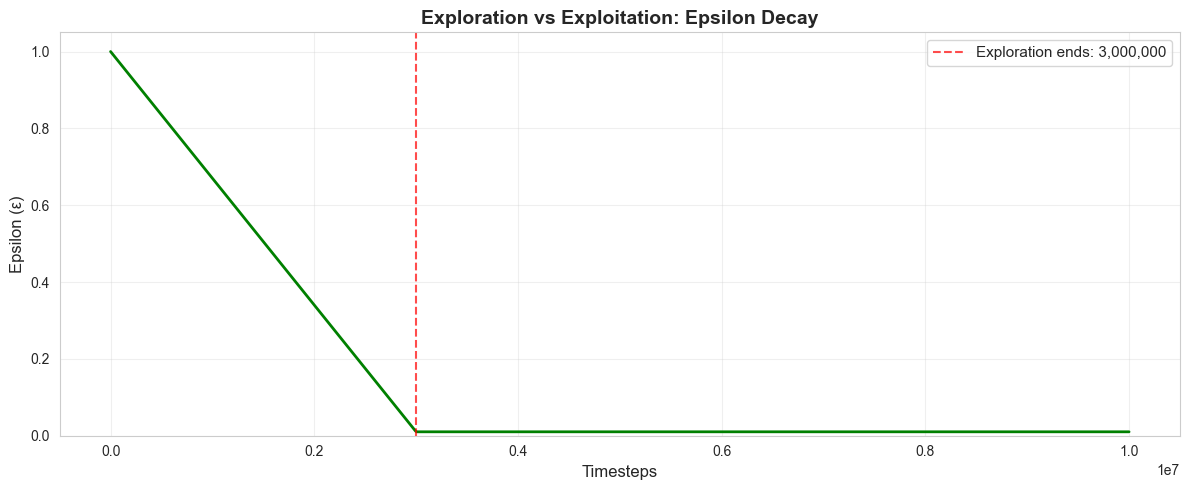

In [8]:
training_plots.plot_epsilon_decay(
    total_timesteps=TOTAL_TIMESTEPS,
    exploration_fraction=agent.hyperparams["exploration_fraction"],
    exploration_final_eps=agent.hyperparams["exploration_final_eps"],
    title="Exploration vs Exploitation: Epsilon Decay",
)

---

# Phase 2: Evaluation & Testing

Run N=100 independent test episodes with deterministic policy (ε=0).


In [ ]:
N_TEST_EPISODES = len(EVAL_SEEDS)

reward_fn = RewardFunction()
test_episodes_dqn = []

print(f"🧪 Running {N_TEST_EPISODES} test episodes with deterministic seeds...")

for ep, seed in tqdm(
    enumerate(EVAL_SEEDS), total=N_TEST_EPISODES, desc="Evaluating DQN"
):
    dqn_env = make_env(random_seed=seed)
    obs, _ = dqn_env.reset()

    dqn_data = {
        "net_inv_0": [],
        "net_inv_1": [],
        "q0": [],
        "q1": [],
        "demand_0": [],
        "demand_1": [],  # Daily demand per product
        "ordering_cost": [],
        "holding_cost": [],
        "shortage_cost": [],
        "total_daily_cost": [],
    }

    done = False
    while not done:
        action = agent.select_action(obs, deterministic=True)
        action_obj = dqn_env.action_space_config.get_action(action)
        obs, reward, terminated, truncated, info = dqn_env.step(action)

        # Log Inventory & Actions
        dqn_data["net_inv_0"].append(info["net_inventory"][0])
        dqn_data["net_inv_1"].append(info["net_inventory"][1])
        dqn_data["q0"].append(action_obj.order_quantities[0])
        dqn_data["q1"].append(action_obj.order_quantities[1])

        # Log Daily Demand per product
        dqn_data["demand_0"].append(info["total_demand"][0])
        dqn_data["demand_1"].append(info["total_demand"][1])

        # Compute Daily Cost Components using RewardFunction
        state = dqn_env.get_current_state()
        costs = reward_fn.calculate_costs(state, action_obj)

        # Append to lists
        dqn_data["ordering_cost"].append(costs.ordering_cost)
        dqn_data["holding_cost"].append(costs.holding_cost)
        dqn_data["shortage_cost"].append(costs.shortage_cost)
        dqn_data["total_daily_cost"].append(costs.total_cost)

        done = terminated or truncated

    test_episodes_dqn.append(dqn_data)

print(f"Collected {N_TEST_EPISODES} test episodes for DQN")

🧪 Running 100 test episodes with deterministic seeds...


Evaluating DQN:   0%|          | 0/100 [00:00<?, ?it/s]

Collected 100 test episodes for DQN


### Warm-up Period Analysis (Welch's Graphical Procedure)

Since the simulation starts with initial inventory conditions, the early data may be biased (transient phase).  
We use Welch's procedure to identify when steady-state begins.


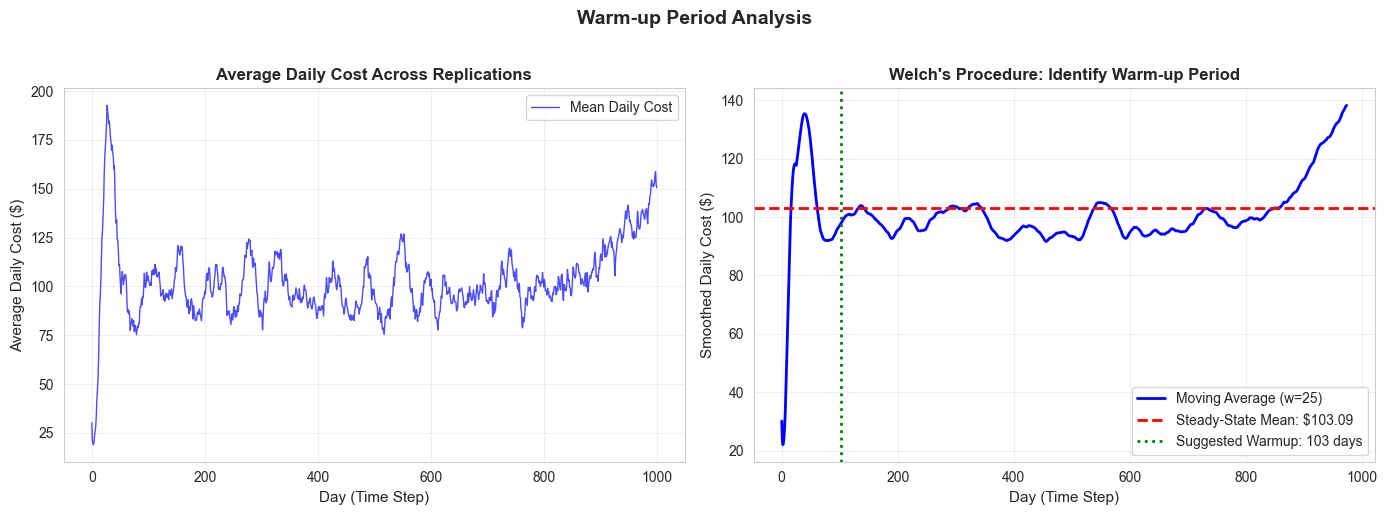

📊 Welch's Procedure Summary:
   Total replications: 100

✅ Suggested Warmup Length: 103 days
   (Detected where curve stays within 5% of steady-state)

💡 Tip: Visually verify the green line on the right plot.
   Adjust manually if needed based on your domain knowledge.


In [21]:
# Welch's Graphical Procedure for Warm-up Detection
n_days, n_reps, WARMUP_LENGTH = evaluation_plots.plot_welch_procedure(
    test_episodes=test_episodes_dqn,
    window_size=25,
    title="Warm-up Period Analysis",
)

## Cost Component Breakdown (Economic Analysis)

In [22]:
# Compute and print evaluation statistics
stats = evaluation_plots.print_evaluation_statistics(
    test_episodes=test_episodes_dqn,
    warmup_length=WARMUP_LENGTH,
)

📊 COST SUMMARY (100 episodes, 897 steady-state days)
  Daily Cost: $102.12 ± $0.96 (95% CI)
  Episode Total: $91603.89 ± $7923.84


### Daily Cost Evolution

Aggregated daily cost statistics across all test episodes.


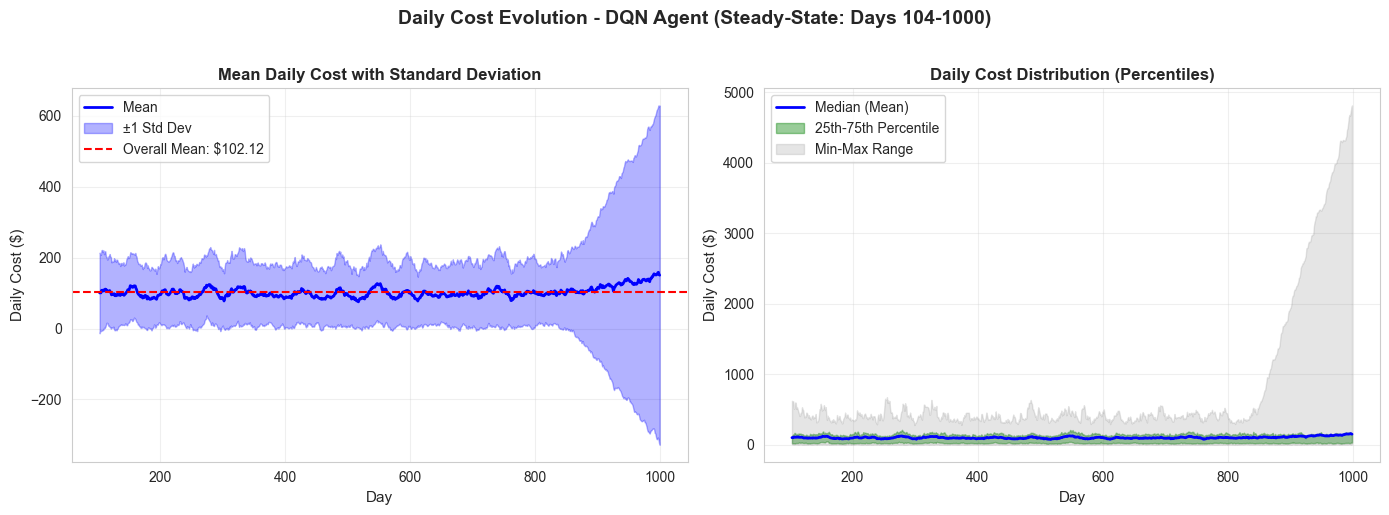

📊 Daily Cost Statistics (Steady-State):
  Mean:   $102.12 ± $121.35
  Median: $99.10
  Min:    $0.00
  Max:    $4813.00
  Range:  $4813.00


In [23]:
# Daily Cost Analysis
evaluation_plots.plot_daily_cost_analysis(
    test_episodes=test_episodes_dqn,
    warmup_length=WARMUP_LENGTH,
    title="Daily Cost Evolution - DQN Agent",
)

Grouped bar chart
decomposed into Ordering, Holding, and Shortage costs.


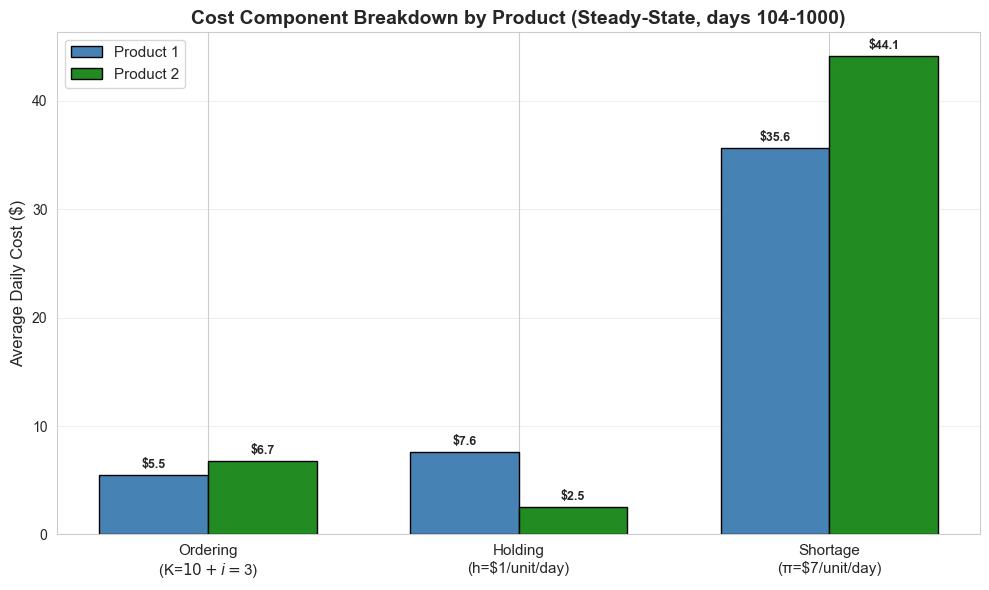

📊 Steady-State Average Daily Cost (days 104-1000):

  Product 1: $48.71 / day
    Ordering: $5.50 (11.3%)
    Holding:  $7.60 (15.6%)
    Shortage: $35.61 (73.1%)

  Product 2: $53.41 / day
    Ordering: $6.75 (12.6%)
    Holding:  $2.55 (4.8%)
    Shortage: $44.11 (82.6%)

------------------------------------------------------------

  TOTAL: $102.12 / day


In [24]:
evaluation_plots.plot_cost_breakdown_by_product(
    test_episodes=test_episodes_dqn,
    warmup_length=WARMUP_LENGTH,
    n_days=n_days,
    title="Cost Component Breakdown by Product",
)

### Operational Time Series (Behavioral Analysis)

Snapshot of inventory levels, orders, and demand over time for selected episodes.


In [25]:
# Select representative episode based on STEADY-STATE costs (excluding warmup)
episode_ss_costs = [
    np.mean(ep["total_daily_cost"][WARMUP_LENGTH:]) for ep in test_episodes_dqn
]
global_ss_mean = np.mean(episode_ss_costs)

# Find episode closest to mean
representative_idx = np.argmin(np.abs(np.array(episode_ss_costs) - global_ss_mean))

# Also find best and worst episodes
best_idx = np.argmin(episode_ss_costs)
worst_idx = np.argmax(episode_ss_costs)

print(f"📊 Episode Selection (Based on Steady-State Costs):")
print(
    f"   Representative: Episode {representative_idx} (cost: ${episode_ss_costs[representative_idx]:.2f})"
)
print(
    f"   Best:           Episode {best_idx} (cost: ${episode_ss_costs[best_idx]:.2f})"
)
print(
    f"   Worst:          Episode {worst_idx} (cost: ${episode_ss_costs[worst_idx]:.2f})"
)
print(f"   Mean across all episodes: ${global_ss_mean:.2f}")

📊 Episode Selection (Based on Steady-State Costs):
   Representative: Episode 23 (cost: $102.24)
   Best:           Episode 84 (cost: $76.57)
   Worst:          Episode 68 (cost: $541.69)
   Mean across all episodes: $102.12



📈 Plotting Representative Episode (Steady-State Period)...


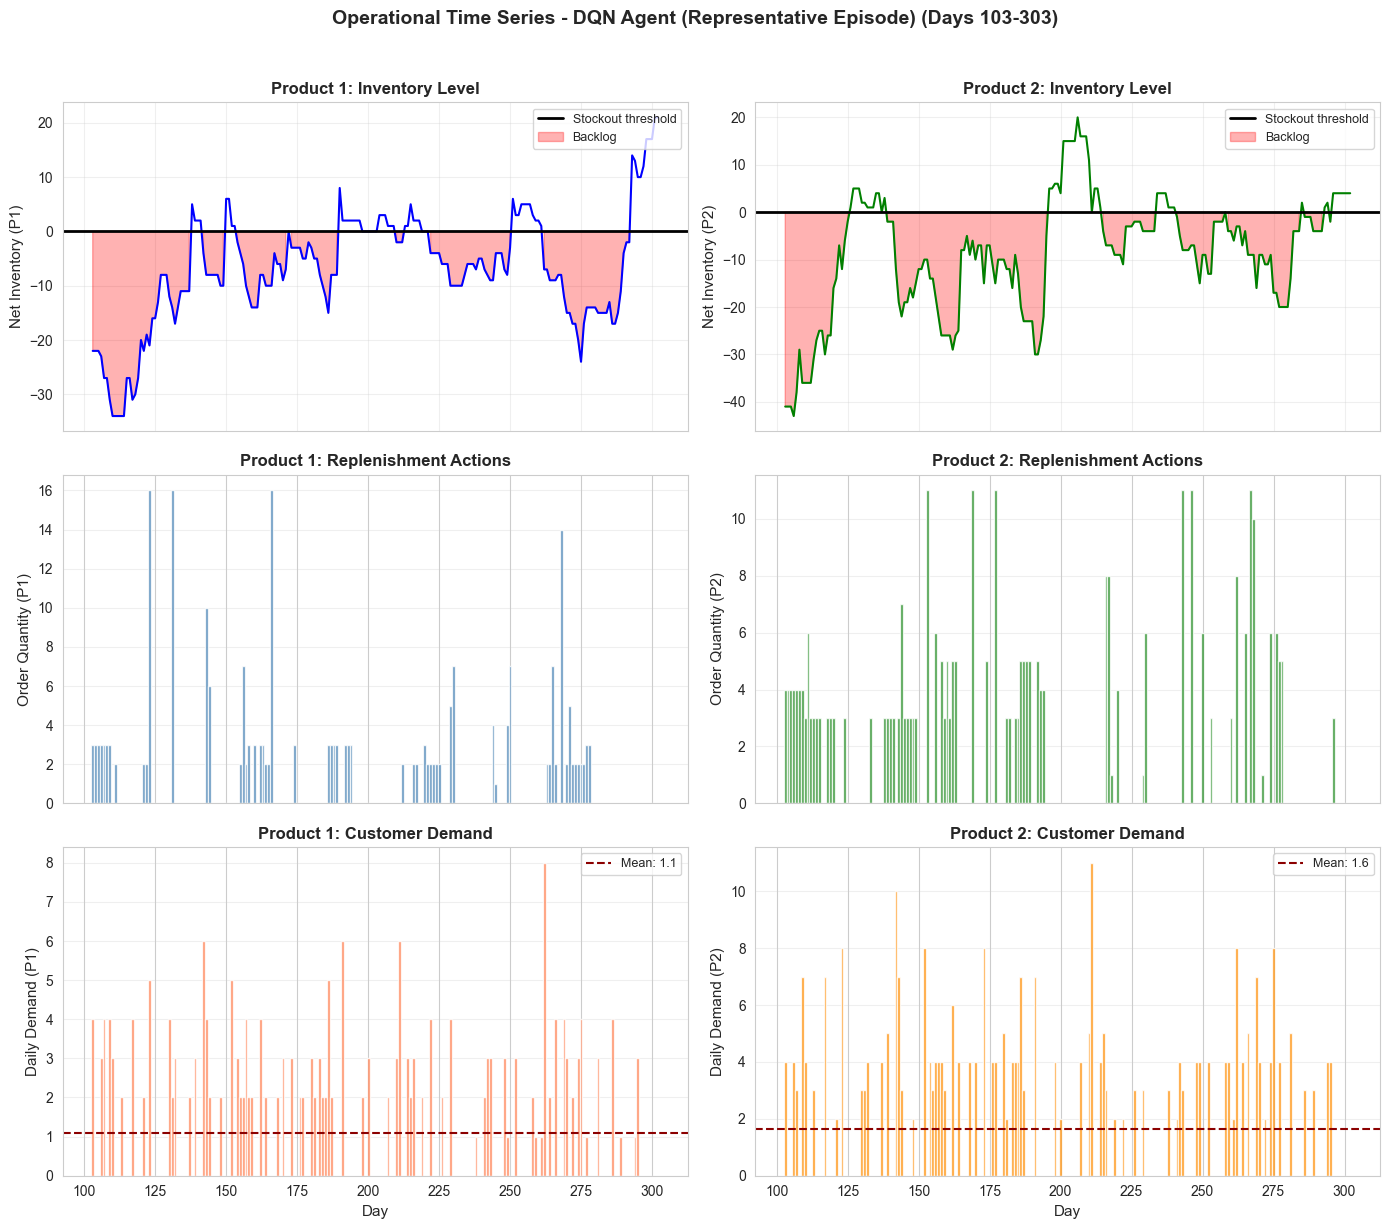

In [26]:
print("\n📈 Plotting Representative Episode (Steady-State Period)...")
evaluation_plots.plot_operational_timeseries(
    episode_data=test_episodes_dqn[representative_idx],
    title="Operational Time Series - DQN Agent (Representative Episode)",
    start_day=WARMUP_LENGTH,
    max_days=200,  # Show only 200 days for clarity
)